# IMPORTS

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!pwd

/content


In [ ]:
#Imports
from zipfile import ZipFile
import os
import pandas as pd
from sklearn.metrics import confusion_matrix, f1_score
from matplotlib import pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from keras.models import Sequential, load_model
from keras.preprocessing import image
import tensorflow as tf
from keras.applications.vgg16 import VGG16
import numpy as np
import keras
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy, F1Score
import seaborn as sns

In [ ]:
if not os.path.exists('/content/dataset'):
  with ZipFile("/content/drive/MyDrive/CS_7643_Project/dataset.zip", 'r') as zObject:
    zObject.extractall(
          path="/content")


In [ ]:
if os.path.exists('/content/dataset'):
  %cd '/content/dataset'
else:
  print("MAKE SURE THE PREVIOUS CELL RAN SUCCESSFULLY")

/content/dataset


# PREPROCESSING

In [ ]:
def create_labeled_csv(dataset_dir, csv_filename):

    for dataset_type in ['train', 'test', 'validate']:
        data = []
        labels = []
        type_dir = os.path.join(dataset_dir, dataset_type)

        if os.path.exists(type_dir):
            fake_dir = os.path.join(type_dir, '1')
            real_dir = os.path.join(type_dir, '0')
            fake_image_files = ['/content/dataset/' + dataset_type + '/1/' + f for f in os.listdir(fake_dir) if f.endswith('.jpg') or f.endswith('.png')]
            real_image_files = ['/content/dataset/' + dataset_type + '/0/' + f for f in os.listdir(real_dir) if f.endswith('.jpg') or f.endswith('.png')]

            # Append filenames and labels (fake or real)
            data.extend(fake_image_files)
            labels.extend(["fake" for f in fake_image_files])
            data.extend(real_image_files)
            labels.extend(["real" for f in real_image_files])

            # Create DataFrame from filenames and labels
            df = pd.DataFrame({'image_filename': data, 'label': labels})

            # Save DataFrame to CSV file
            df.to_csv(csv_filename + "_" + dataset_type + ".csv", index=False)

            print(f"CSV file '{csv_filename}_{dataset_type}.csv' created successfully.")

# Specify the directory containing train, test, and validate datasets
dataset_directory = '/content/dataset'
csv_filename = 'image_labels'
create_labeled_csv(dataset_directory, csv_filename)

CSV file 'image_labels_train.csv' created successfully.
CSV file 'image_labels_test.csv' created successfully.
CSV file 'image_labels_validate.csv' created successfully.


In [ ]:
df_train = pd.read_csv('/content/dataset/image_labels_train.csv')
df_validate = pd.read_csv('/content/dataset/image_labels_validate.csv')
df_test = pd.read_csv('/content/dataset/image_labels_test.csv')

In [ ]:
display(df_train)

,image_filename,label
0,/content/dataset/train/1/35875946056df679dc2f9...,fake
1,/content/dataset/train/1/22f84ee0ab10a57bfc8a7...,fake
2,/content/dataset/train/1/0fcdc264defba687476c9...,fake
3,/content/dataset/train/1/3fe5390435f1cb23b574f...,fake
4,/content/dataset/train/1/4a339537bd632f478d415...,fake
...,...,...
72569,/content/dataset/train/0/39609.jpg,real
72570,/content/dataset/train/0/07335.jpg,real
72571,/content/dataset/train/0/47247.jpg,real
72572,/content/dataset/train/0/13085.jpg,real


In [ ]:
display(df_validate)

,image_filename,label
0,/content/dataset/validate/1/016d6f73a324620fb4...,fake
1,/content/dataset/validate/1/50ee89d5a566f8efb6...,fake
2,/content/dataset/validate/1/3a78b8d5559f29c75c...,fake
3,/content/dataset/validate/1/SFHQ_pt4_00004108.jpg,fake
4,/content/dataset/validate/1/a1497d21a421104605...,fake
...,...,...
24185,/content/dataset/validate/0/60928.jpg,real
24186,/content/dataset/validate/0/61885.jpg,real
24187,/content/dataset/validate/0/58901.jpg,real
24188,/content/dataset/validate/0/52815.jpg,real


In [ ]:
display(df_test)

,image_filename,label
0,/content/dataset/test/1/SFHQ_pt3_00002002.jpg,fake
1,/content/dataset/test/1/SFHQ_pt2_00064122.jpg,fake
2,/content/dataset/test/1/fb6ca328b4fad9813d04bd...,fake
3,/content/dataset/test/1/SFHQ_pt4_00000733.jpg,fake
4,/content/dataset/test/1/SFHQ_pt2_00012162.jpg,fake
...,...,...
24185,/content/dataset/test/0/14602.jpg,real
24186,/content/dataset/test/0/59617.jpg,real
24187,/content/dataset/test/0/18729.jpg,real
24188,/content/dataset/test/0/63749.jpg,real


In [ ]:
example_validation_image_path = '/content/dataset/validate/1/SFHQ_pt1_00017991.jpg'
img = Image.open(example_validation_image_path)
width, height = img.size
print(f"Image size: {width} x {height}")

Image size: 512 x 512


In [ ]:
target_size = (256, 256)

In [ ]:
datagen = ImageDataGenerator(rescale=1./255)
train_data_generator = datagen.flow_from_dataframe(
    dataframe=df_train,
    x_col='image_filename',
    y_col='label',
    target_size=target_size,
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=26,
    classes=["real", "fake"]
)

Found 72574 validated image filenames belonging to 2 classes.


In [ ]:
validation_data_generator = datagen.flow_from_dataframe(
    dataframe=df_validate,
    x_col='image_filename',
    y_col='label',
    target_size=target_size,
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=26,
    classes=["real", "fake"]
)

Found 24190 validated image filenames belonging to 2 classes.


In [ ]:
test_data_generator = datagen.flow_from_dataframe(
    dataframe=df_test,
    x_col='image_filename',
    y_col='label',
    target_size=target_size,
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=26,
    classes=["real", "fake"]
)

Found 24190 validated image filenames belonging to 2 classes.


In [ ]:
print(train_data_generator.class_indices)
print(train_data_generator[0][0].shape)
print(train_data_generator[0][1].shape)

{'real': 0, 'fake': 1}
(32, 256, 256, 3)
(32, 2)


# Custom Model

In [ ]:
EPOCHS = 15

In [ ]:
custom_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding="same", input_shape=(target_size[0], target_size[1], 3)),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPool2D((2, 2), strides=(2, 2)),

    tf.keras.layers.Conv2D(32, (3, 3), padding="same"),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPool2D((2, 2), strides=(2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), padding="same"),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPool2D((2, 2), strides=(2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), padding="same"),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPool2D((2, 2), strides=(2, 2)),

    tf.keras.layers.Conv2D(128, (3, 3), padding="same"),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPool2D((2, 2), strides=(2, 2)),

    tf.keras.layers.Conv2D(256, (3, 3), padding="same"),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPool2D((2, 2), strides=(2, 2)),

    tf.keras.layers.Conv2D(512, (5, 5), padding="same"),
    tf.keras.layers.ReLU(),
    tf.keras.layers.AvgPool2D((2, 2), strides=(2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(2, activation="sigmoid")
])
custom_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 re_lu (ReLU)                (None, 256, 256, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 re_lu_1 (ReLU)              (None, 128, 128, 32)      0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                   

In [ ]:
custom_model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy", Precision(), Recall()]
)

In [ ]:
# custom_model = load_model('/content/drive/MyDrive/CS_7643_Project/custom_model_it4.keras')
history = custom_model.fit(x=train_data_generator,
          validation_data=validation_data_generator,
          epochs=EPOCHS)

Epoch 1/15
2268/2268 [==============================] - 370s 157ms/step - loss: 0.5213 - accuracy: 0.7371 - precision: 0.7373 - recall: 0.7364 - val_loss: 0.4314 - val_accuracy: 0.8026 - val_precision: 0.8039 - val_recall: 0.8006
Epoch 2/15
2268/2268 [==============================] - 329s 145ms/step - loss: 0.3205 - accuracy: 0.8642 - precision: 0.8645 - recall: 0.8640 - val_loss: 0.2942 - val_accuracy: 0.8747 - val_precision: 0.8748 - val_recall: 0.8749
Epoch 3/15
2268/2268 [==============================] - 323s 142ms/step - loss: 0.2391 - accuracy: 0.9026 - precision: 0.9025 - recall: 0.9027 - val_loss: 0.2174 - val_accuracy: 0.9152 - val_precision: 0.9152 - val_recall: 0.9151
Epoch 4/15
2268/2268 [==============================] - 301s 133ms/step - loss: 0.1920 - accuracy: 0.9246 - precision: 0.9246 - recall: 0.9247 - val_loss: 0.1919 - val_accuracy: 0.9243 - val_precision: 0.9238 - val_recall: 0.9245
Epoch 5/15
2268/2268 [==============================] - 310s 137ms/step - loss: 

In [ ]:
"""
prediction = []
ground_truth = []
for batch in test_data_generator:
    X, y = batch
    yhat = custom_model.predict(X)

    for i in yhat:
      prediction.append([np.argmax(i)])

    for i in y:
      ground_truth.append([np.argmax(i)])

accuracy = keras.metrics.Accuracy()
accuracy.update_state(prediction, ground_truth)
accuracy.result()
"""

print(custom_model.evaluate(x=test_data_generator))

756/756 [==============================] - 87s 115ms/step - loss: 0.2017 - accuracy: 0.9382 - precision: 0.9382 - recall: 0.9381
[0.20167188346385956, 0.9381976127624512, 0.9381511211395264, 0.9380735754966736]


In [ ]:
custom_model.save('/content/drive/MyDrive/CS_7643_Project/custom_model_it5.keras')

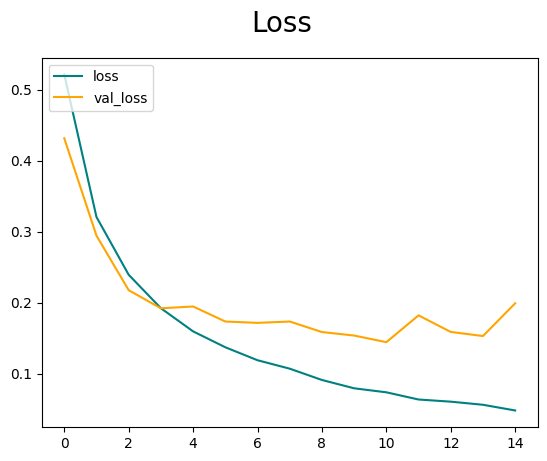

In [ ]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal',label='loss')
plt.plot(history.history['val_loss'], color='orange',label='val_loss')
fig.suptitle('Loss',fontsize=20)
plt.legend(loc="upper left")
plt.show()

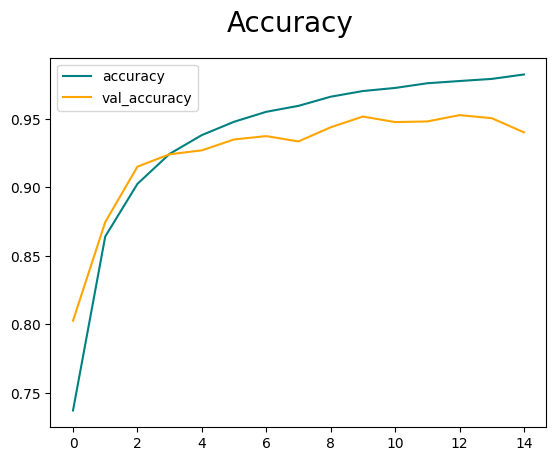

In [ ]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal',label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange',label='val_accuracy')
fig.suptitle('Accuracy',fontsize=20)
plt.legend(loc="upper left")
plt.show()

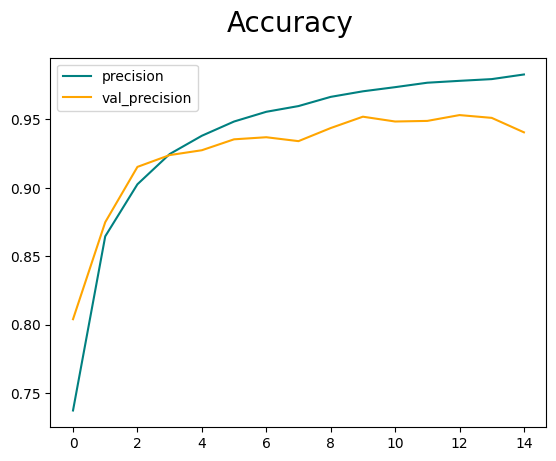

In [ ]:
fig = plt.figure()
plt.plot(history.history['precision'], color='teal',label='precision')
plt.plot(history.history['val_precision'], color='orange',label='val_precision')
fig.suptitle('Accuracy',fontsize=20)
plt.legend(loc="upper left")
plt.show()

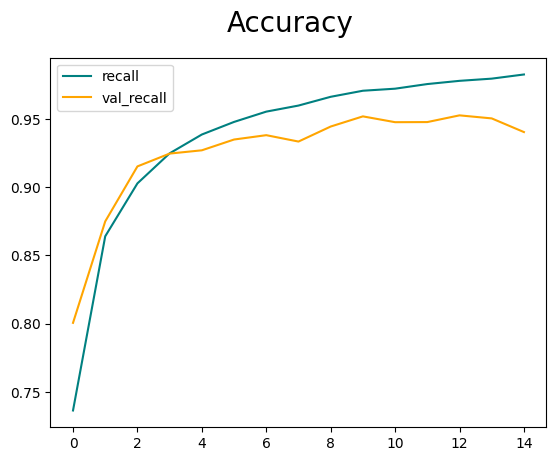

In [ ]:
fig = plt.figure()
plt.plot(history.history['recall'], color='teal',label='recall')
plt.plot(history.history['val_recall'], color='orange',label='val_recall')
fig.suptitle('Accuracy',fontsize=20)
plt.legend(loc="upper left")
plt.show()

# EfficientNet

# VGG16

In [ ]:
print(train_data_generator[0][0].shape)
print(train_data_generator[0][1].shape)
print(train_data_generator[0][1])
# USE fit_generator()

In [ ]:
PRETRAINED = None
IMAGE_SHAPE = (512, 512, 3)
EPOCHS = 3

In [ ]:
vgg16_base = VGG16(
    include_top=False,
    weights=PRETRAINED,
    input_tensor=None,
    input_shape=IMAGE_SHAPE,
    pooling="avg"
)
vgg16_base.trainable = True

In [ ]:
vgg_model = tf.keras.models.Sequential([
    vgg16_base,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation="relu"),
    tf.keras.layers.Dense(2, activation="sigmoid")
])

In [ ]:
vgg_model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
vgg_model.fit(x=train_data_generator,
          validation_data=validation_data_generator,
          epochs=EPOCHS)

Epoch 1/3
2268/2268 [==============================] - 1243s 535ms/step - loss: 0.7014 - accuracy: 0.5786 - val_loss: 0.6809 - val_accuracy: 0.5788
Epoch 2/3
2268/2268 [==============================] - 1192s 526ms/step - loss: 0.6809 - accuracy: 0.5787 - val_loss: 0.6808 - val_accuracy: 0.5788
Epoch 3/3
2268/2268 [==============================] - 1184s 522ms/step - loss: 0.6808 - accuracy: 0.5787 - val_loss: 0.6807 - val_accuracy: 0.5788


In [ ]:
vgg_model.save('/content/drive/MyDrive/CS_7643_Project/vgg_model.keras')

# Test

In [ ]:
def test_model(file_path):
  custom_model = load_model('/content/drive/MyDrive/CS_7643_Project/custom_model_it5.keras')
  image = Image.open(file_path)
  image = image.resize((512,512))
  image = image.convert('RGB')
  print(image.size)
  display(image)
  image = image.resize(target_size)
  image = np.array(image) / 255.0
  image = np.expand_dims(image, axis=0)
  result = custom_model.predict(image)
  predicted_class = np.argmax(result, axis=1)[0]
  class_labels = ["real", "fake"]
  predicted_label = class_labels[predicted_class]
  print("Predicted Label:", predicted_label)

(512, 512)


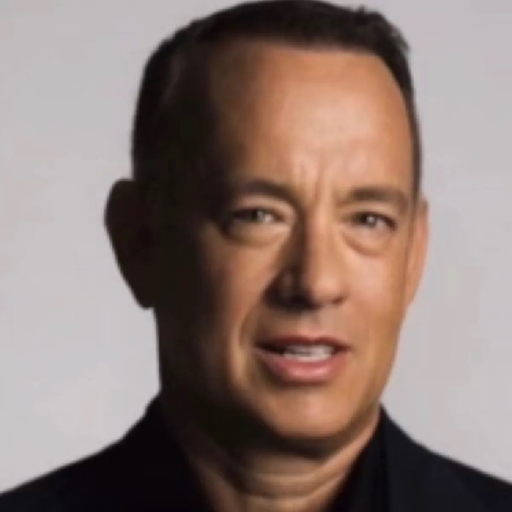

1/1 [==============================] - 0s 120ms/step
Predicted Label: fake


In [ ]:
# test_model('/content/dataset/test/1/00408129ce3281fad7c9935fc12a681c8baa9b3c.jpg')
test_model('/content/tom-hanks-fake-2.jpeg')